# Numerical Results for the A+B→C Network

Compare master operator and/or Gillespie simulation to linear noise (LNA), moment closure and Plefka approximation

In [1]:
using CRN
using PyPlot
PyPlot.PyDict(PyPlot.matplotlib."rcParams")["font.size"] = 16
using LinearAlgebra
using OrdinaryDiffEq

In [2]:
function ABC_params()
    
    # Parameters
    num_species = 3     # number of species
    num_int = 1         # number of interaction reaction

    # Reaction constants
    k1 = [8, 8, 3]      # Creation
    k2 = [3, 2, 1.5]    # Annihiliation
    k3 = [0.5]          # Interaction
    k = [k1, k2, k3]

    # Stoichiometric
    s_i = zeros(Int, num_int, num_species)
    r_i = copy(s_i)
    s_i[1,:] = [0 0 1]
    r_i[1,:] = [1 1 0]

    # Times
    t_init = 0.0        # Start time
    t_final = 5.0       # End time
    delta_t = 0.01      # time step

    # Initial condition
    x0 = k1 ./ k2
    
    return Parameters(x0, k, s_i, r_i, t_init, t_final, delta_t)
end
p = ABC_params()
ts = tspan(p);

## Master operator

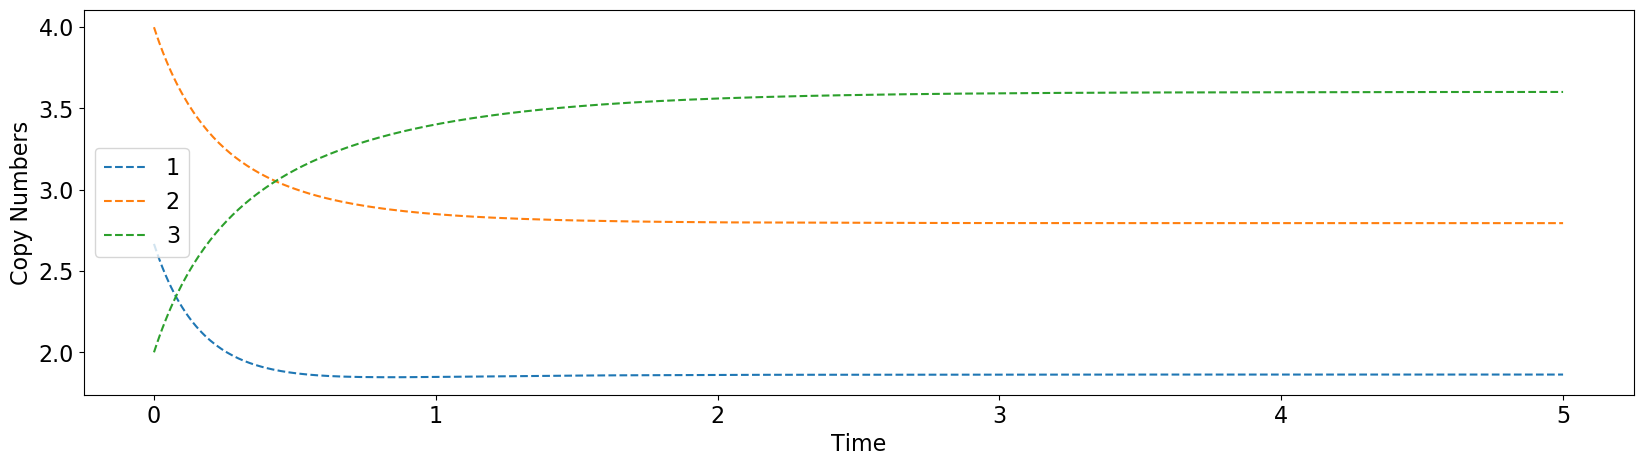

PyObject Text(32.999999999999986, 0.5, 'Copy Numbers')

In [3]:
max_num = get_max_num(p.x0, 1e-4)   # Truncation of state space
(m,s) = master_operator(p, max_num) # Master operator and state space

# Solving the ODE dP/dt = M*P with Runge-Kutta (RK4)
res_mOP = dynamics_masterOP(m, s, ts, p.x0, RK4)

### Could also be done with matrix exponentiation, takes more time!
# E = eigen(m, sortby=nothing)        # Eigenvalues and eigenvectors
# res_mOP = dynamics_masterOP_diag(m, s, E, ts, p.x0)  

plot_trajectories(res_mOP)

## Gillespie Simulation

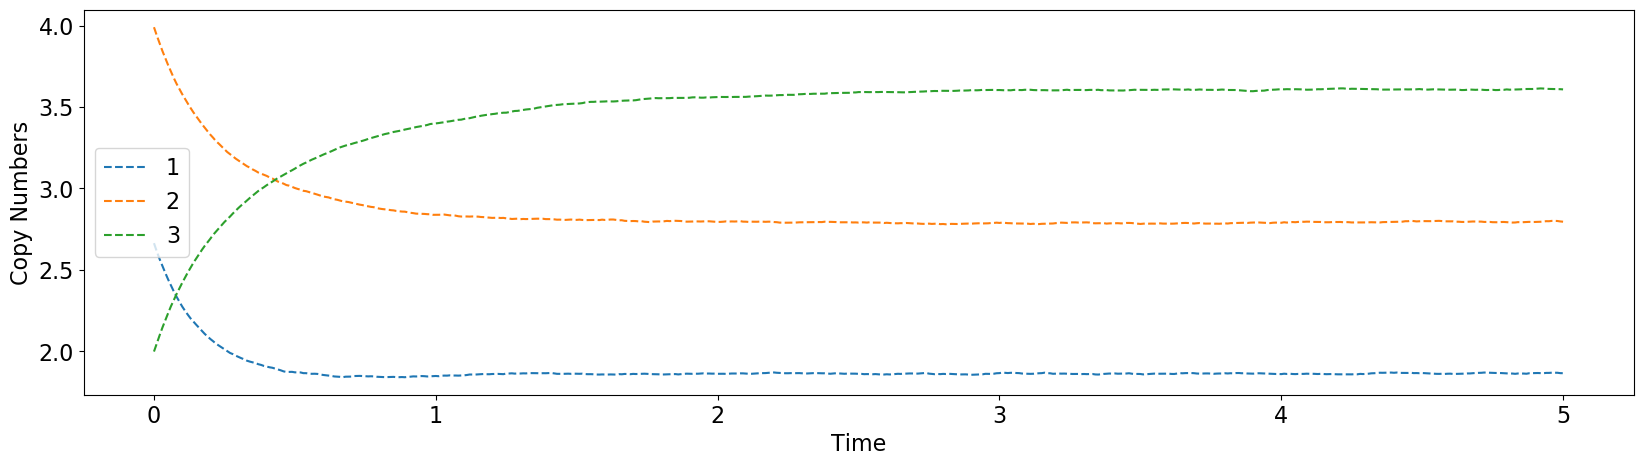

PyObject Text(32.999999999999986, 0.5, 'Copy Numbers')

In [4]:
N = 100000   # Repititions
res_gil = gillespie_avg(p.x0, p.k, p.s_i, p.r_i, ts, N)
plot_trajectories(res_gil)

In [5]:
# Choose reference for further studies:
ref = res_mOP;  
#or ref = res_gil

## Linear noise approximation (LNA)

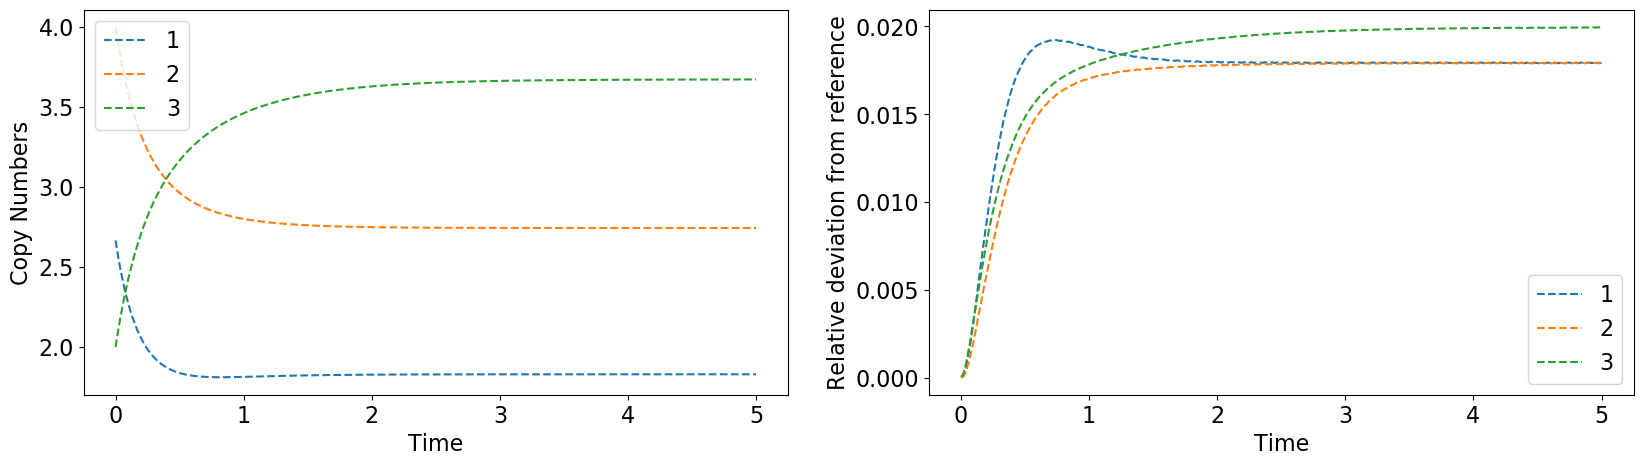

PyObject Text(850.2045454545454, 0.5, 'Relative deviation from reference')

In [6]:
function f_LNA!(du,u,k,t)
    du[1] = k[1][1] - k[2][1]*u[1] - k[3][1]*u[1]*u[2]
    du[2] = k[1][2] - k[2][2]*u[2] - k[3][1]*u[1]*u[2]
    du[3] = k[1][3] - k[2][3]*u[3] + k[3][1]*u[1]*u[2]
end
res_lna = ode_solver(f_LNA!, p.k, ts, p.x0, RK4)
plot_trajectories_and_deviation(res_lna, ref)

## Moment closure approximation

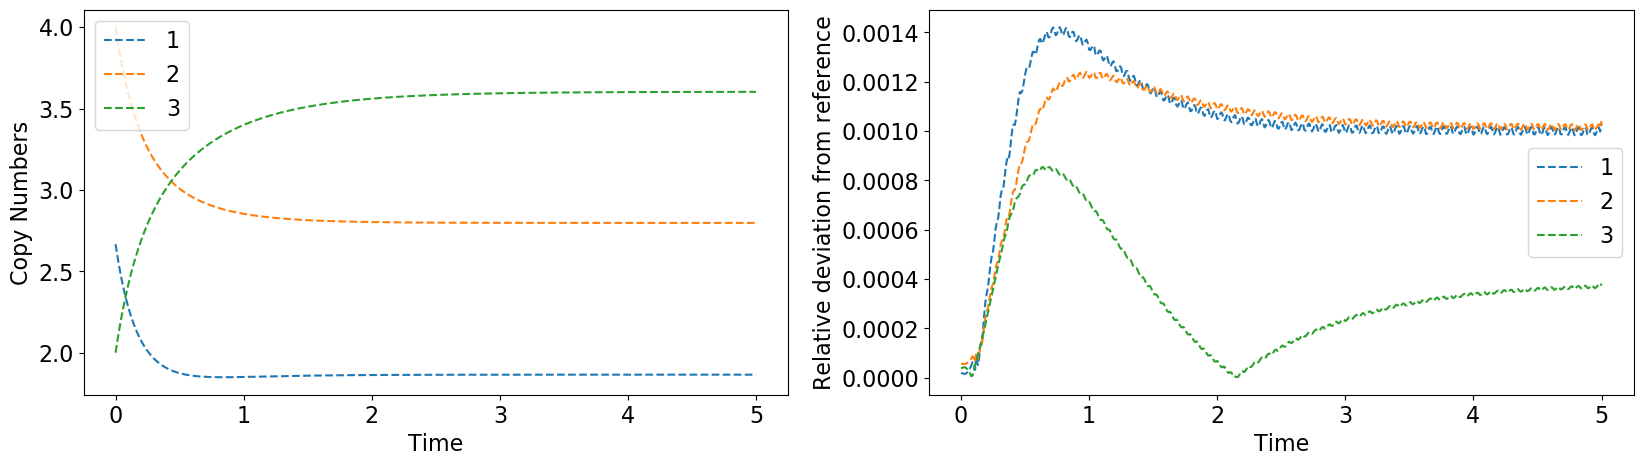

PyObject Text(836.0795454545454, 0.5, 'Relative deviation from reference')

In [7]:
function moment_eq!(du,u,k,t)
    du[1] = k[1][1] - k[2][1]*u[1] - k[3][1]*(u[4] + u[1]*u[2]) # A
    du[2] = k[1][2] - k[2][2]*u[2] - k[3][1]*(u[4] + u[1]*u[2]) # B
    du[3] = k[1][3] - k[2][3]*u[3] + k[3][1]*(u[4] + u[1]*u[2]) # C
    du[4] = -(k[2][1]+k[2][2])*u[4] + k[3][1]*u[4]*(1 - u[1] - u[2]) + k[3][1]*u[1]*u[2] - k[3][1]*u[2]*u[5] - k[3][1]*u[1]*u[6] # AB
    du[5] = k[1][1] - 2*(k[2][1] + k[3][1]*u[2])*u[5] + k[3][1]*(1-2*u[1])*u[4] + k[2][1]*u[1] + k[3][1]*u[1]*u[2] # AA
    du[6] = k[1][2] - 2*(k[2][2] + k[3][1]*u[1])*u[6] + k[3][1]*(1-2*u[2])*u[4] + k[2][2]*u[2] + k[3][1]*u[1]*u[2] # BB
end
u0 = [p.x0..., 0, p.x0[1], p.x0[2]]
sol_mom = ode_solver(moment_eq!, p.k, ts, u0, RK4)
res_mom = Result(sol_mom.time, sol_mom.data[1:3,:])
plot_trajectories_and_deviation(res_mom, ref)

## Plefka with linear O.P. and power α¹ 

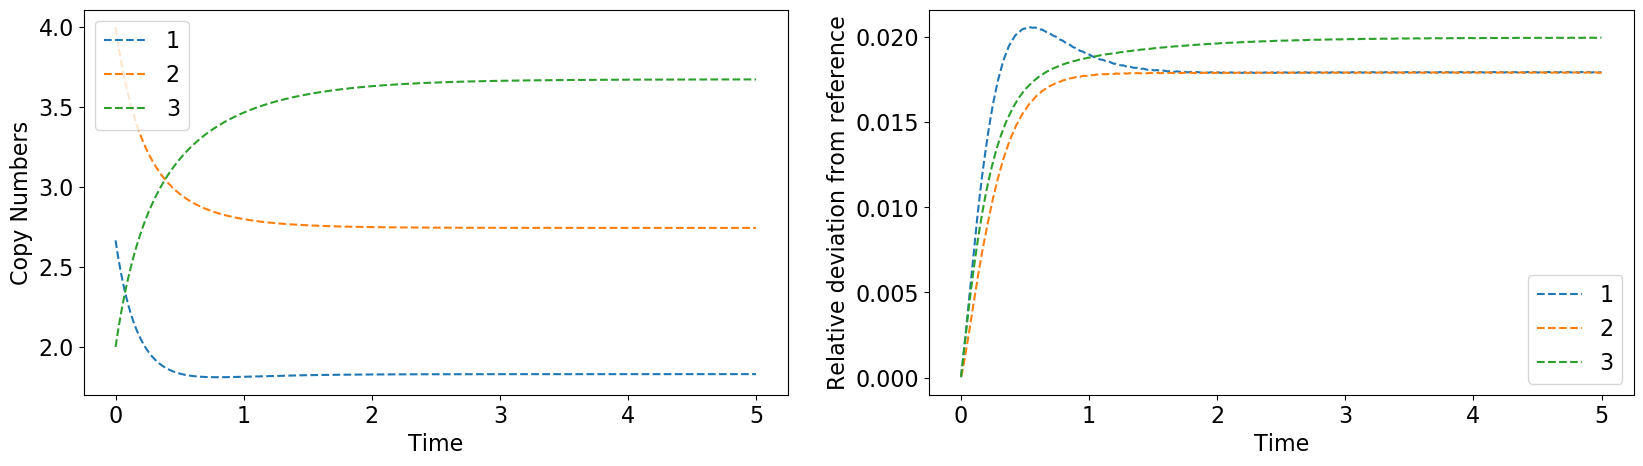

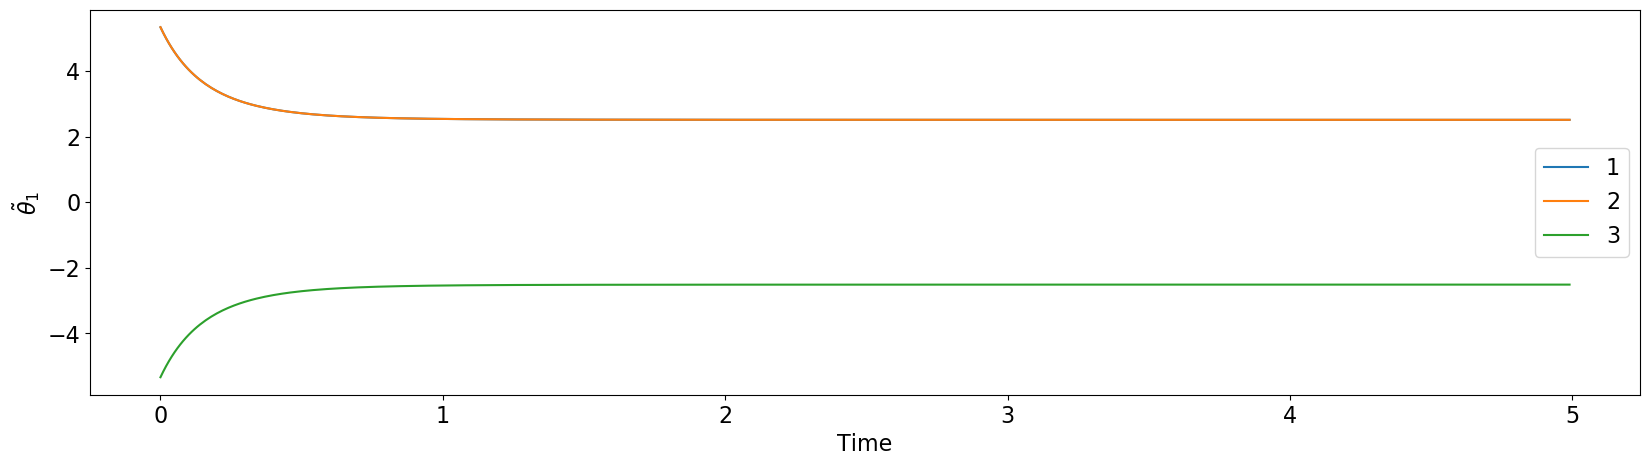

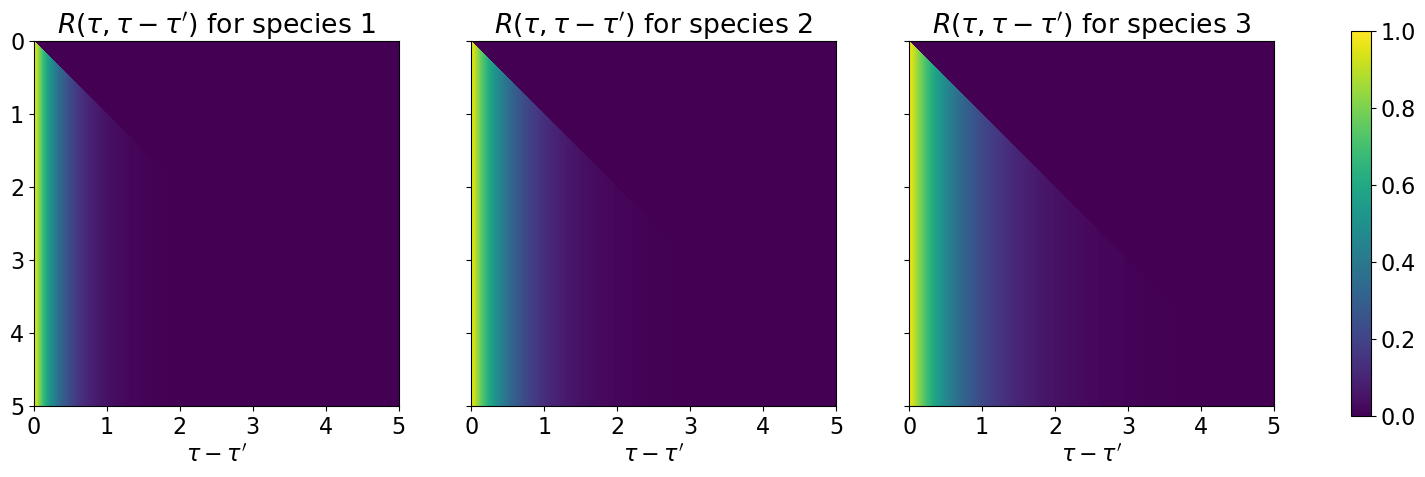

In [8]:
plf11 = Plefka(1.0, 1, "linear") # α, alphaOrder, orderParameter
res_plf_11 = euler_step(p, plf11)
plot_trajectories_and_deviation(res_plf_11[1], ref)
plot_hatTheta(ts, res_plf_11[3])
plot_responses(res_plf_11[2])

## Plefka with linear O.P. and power α²

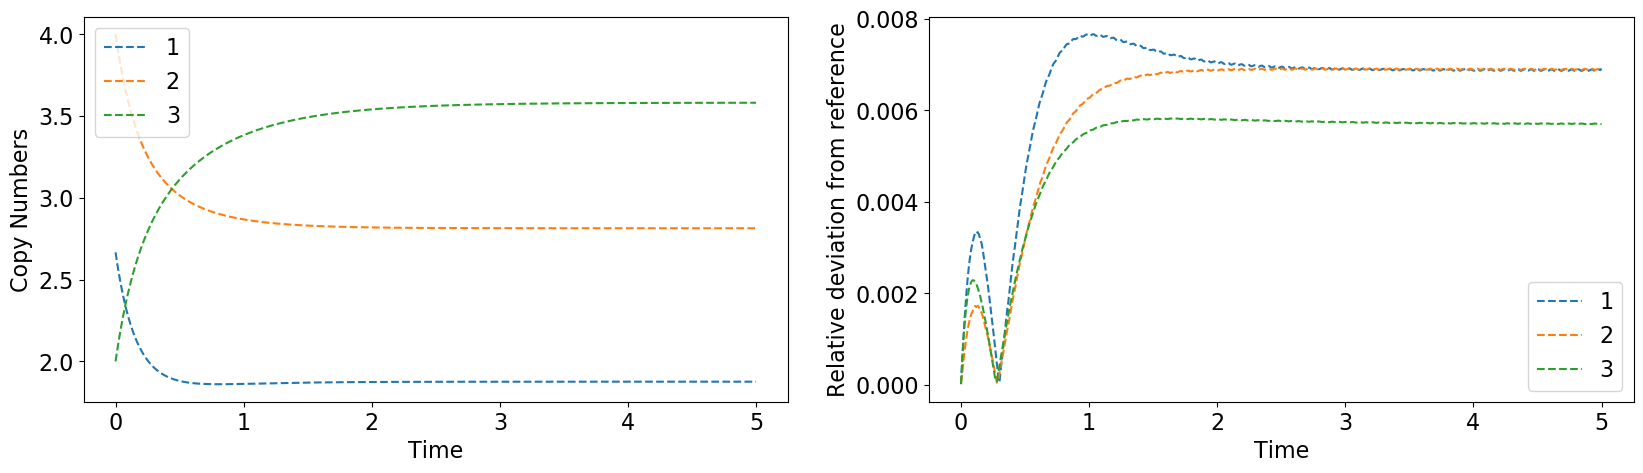

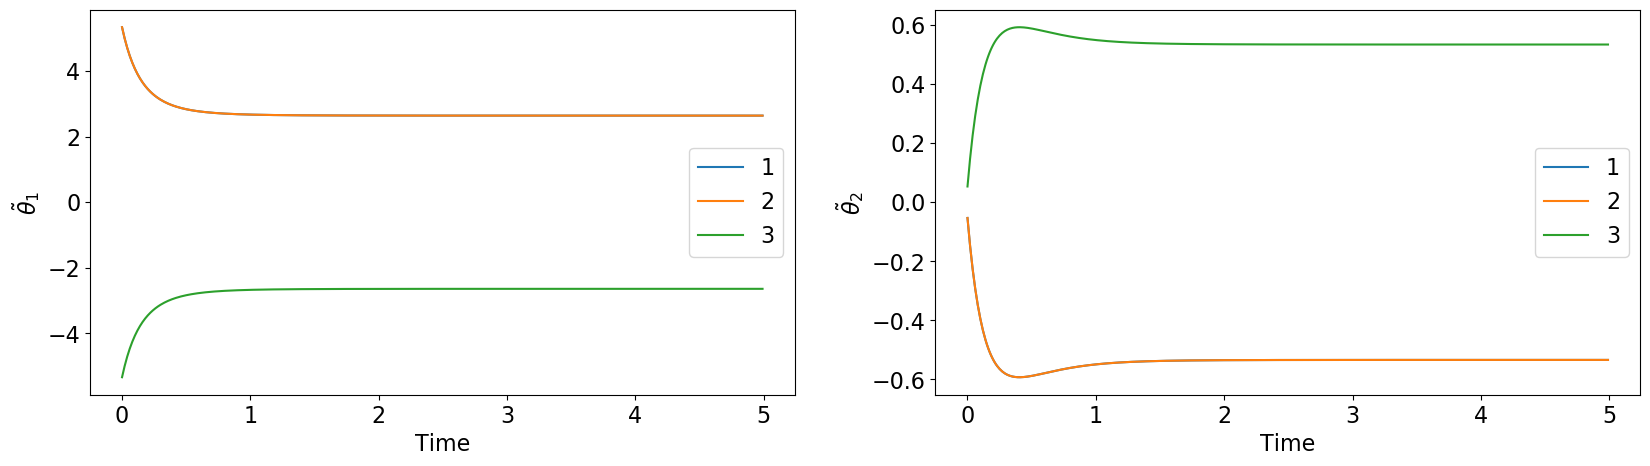

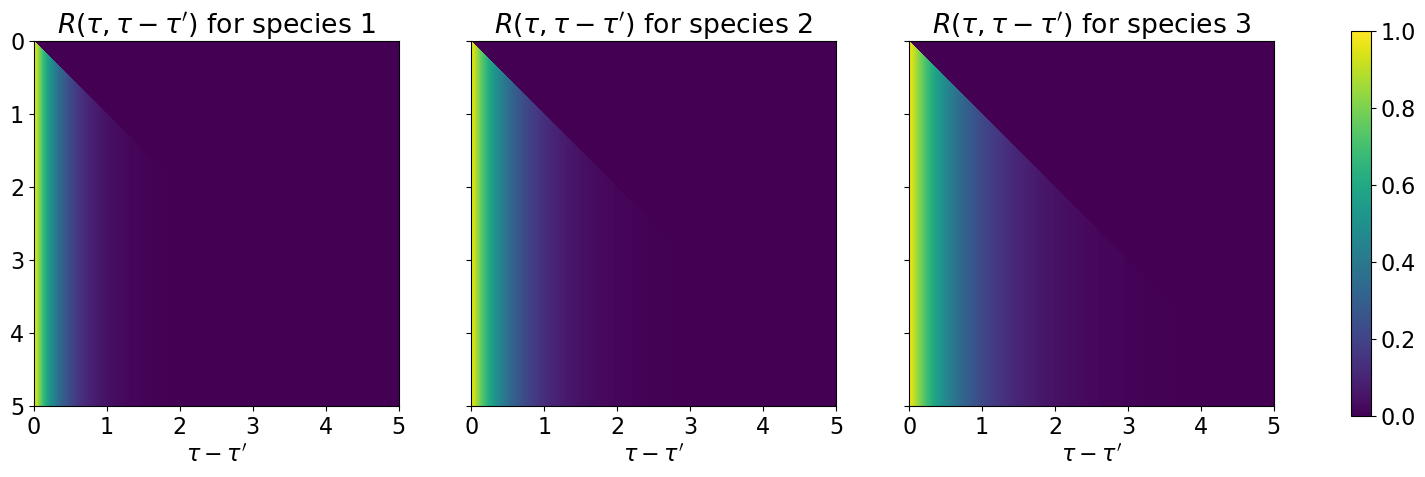

In [9]:
plf21 = Plefka(1.0, 2, "linear") # α, alphaOrder, orderParameter
res_plf_21 = euler_step(p, plf21)
plot_trajectories_and_deviation(res_plf_21[1], ref)
plot_hatTheta(ts, res_plf_21[3])
plot_responses(res_plf_21[2])

## Plefka with quad O.P. and power α¹ 

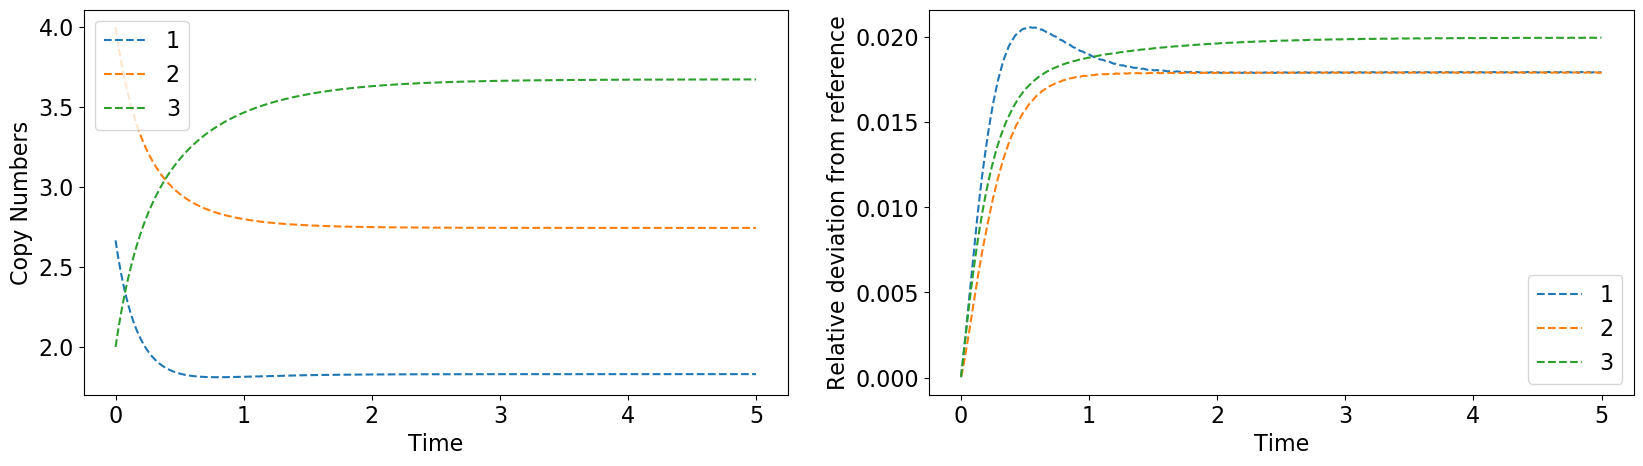

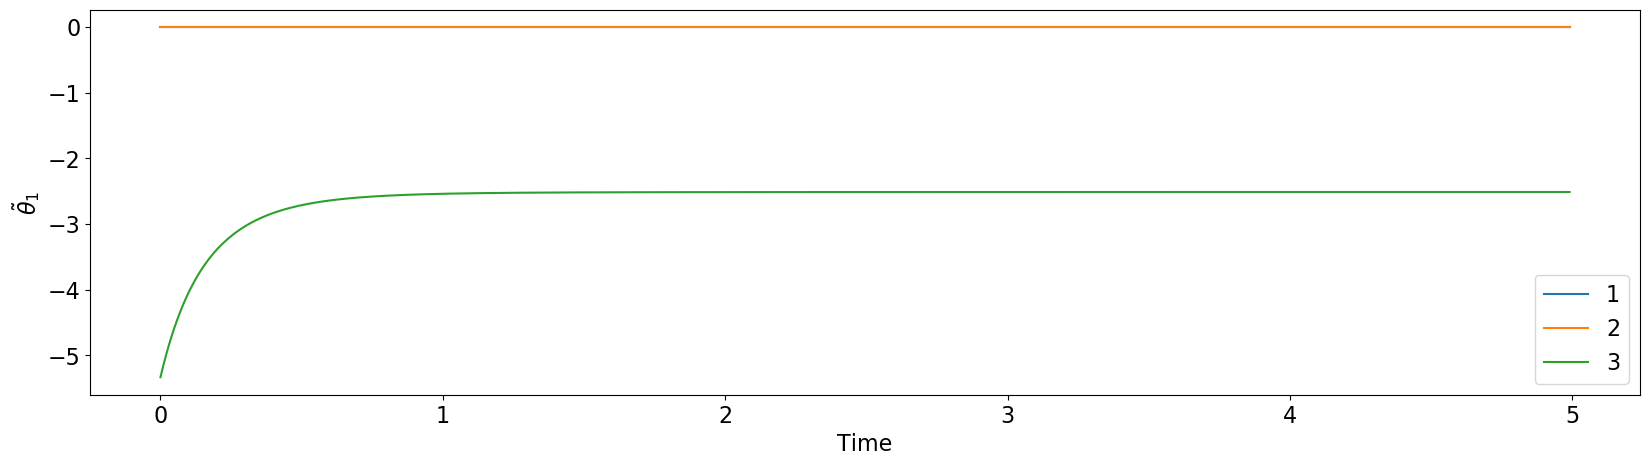

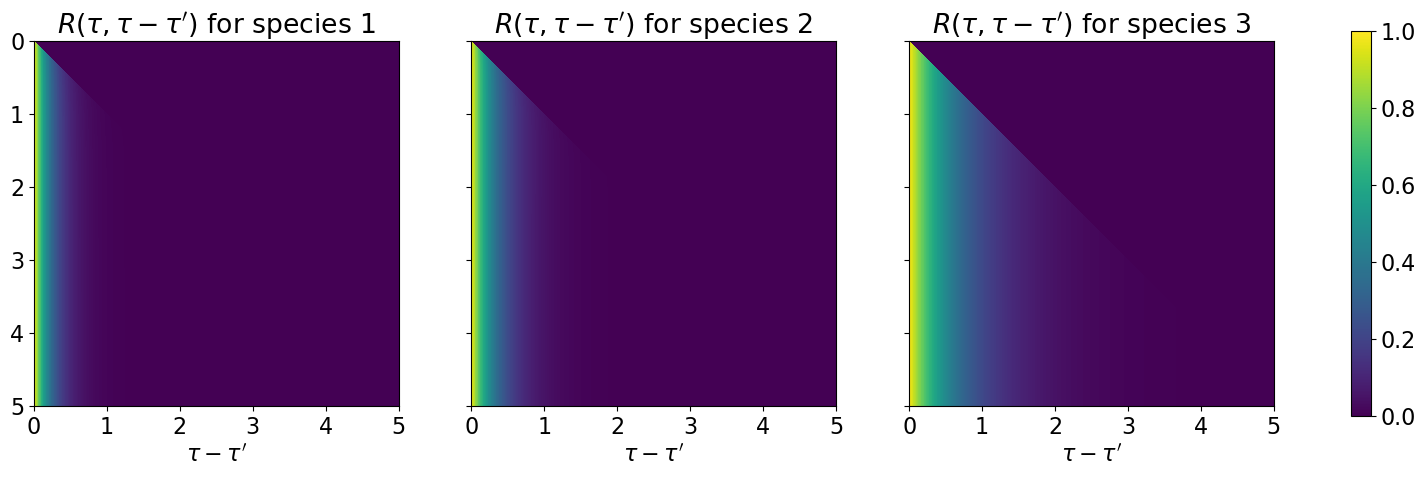

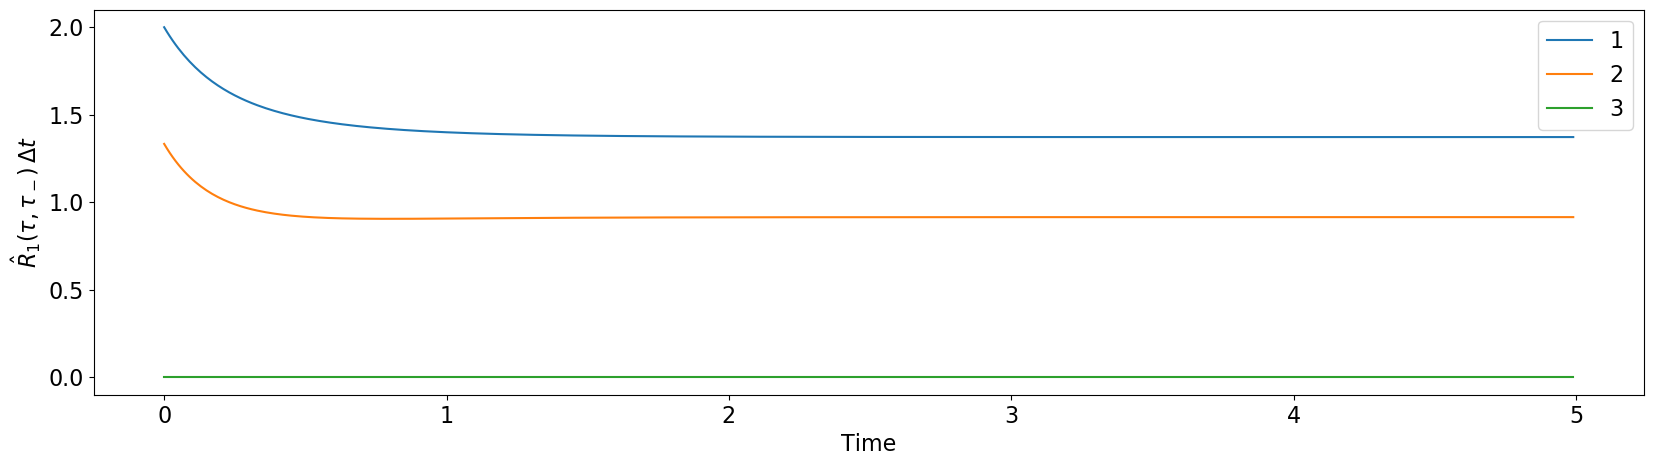

PyObject Text(43.17777777777776, 0.5, '$\\hat{R}_1(\\tau,\\tau_-)\\,\\Delta t$')

In [10]:
plf12 = Plefka(1.0, 1, "quad") # α, alphaOrder, orderParameter
res_plf_12 = euler_step(p, plf12)
plot_trajectories_and_deviation(res_plf_12[1], ref)
plot_hatTheta(ts, res_plf_12[3])
plot_responses(res_plf_12[2])
plot_hatR_diag(ts, res_plf_12[3])

## Plefka with quad O.P. and power α²

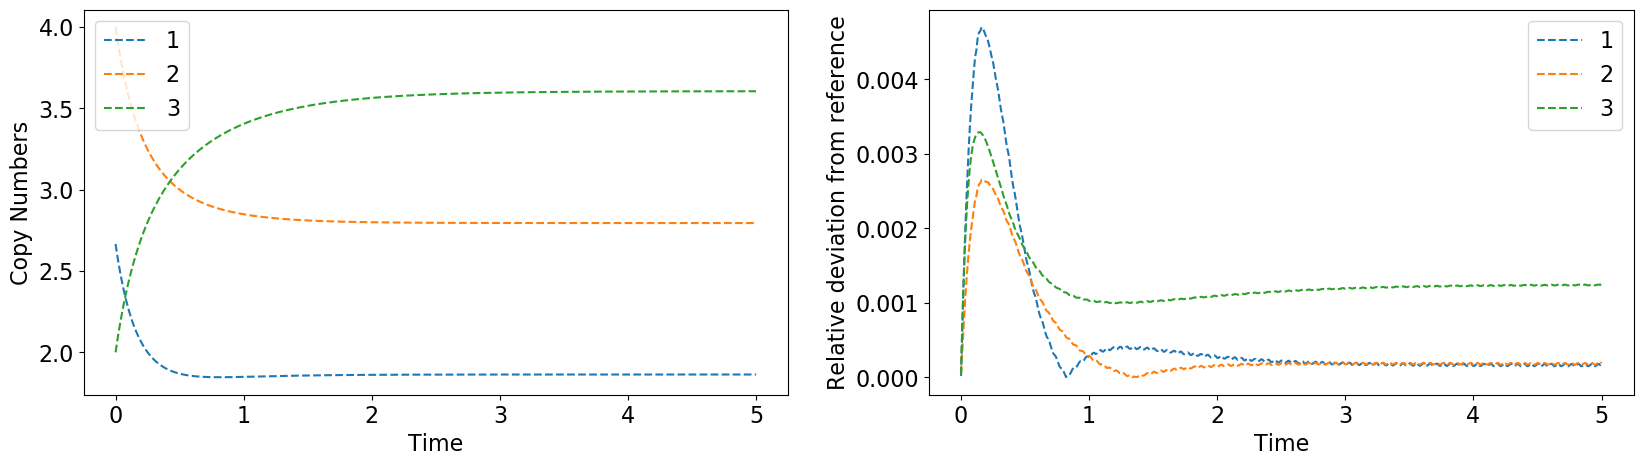

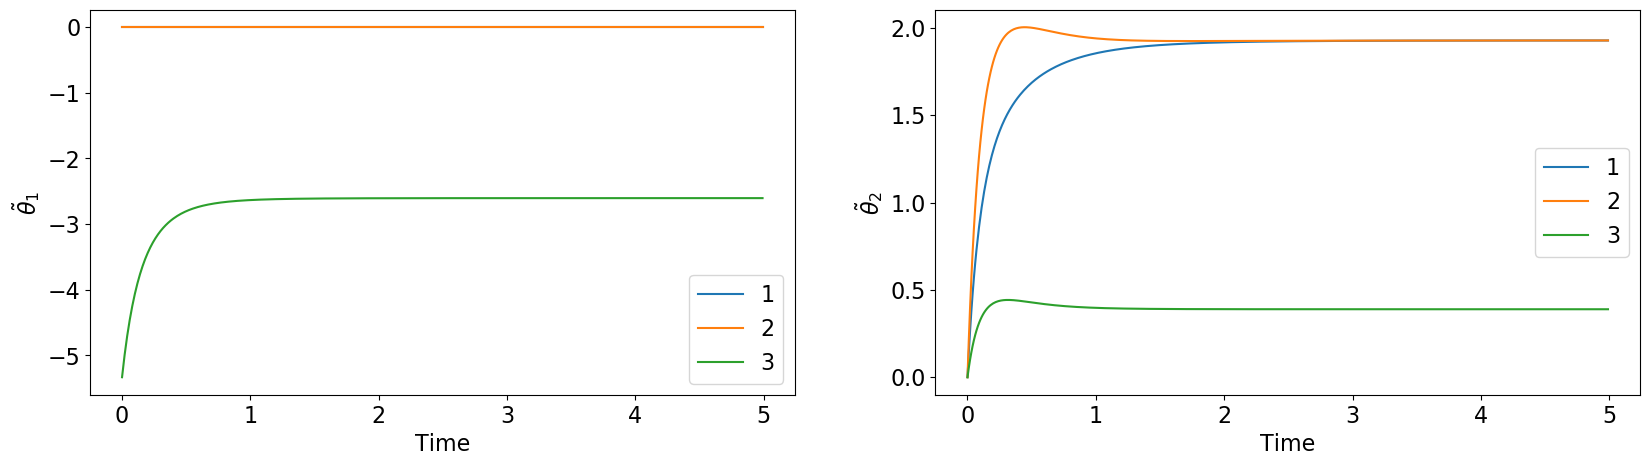

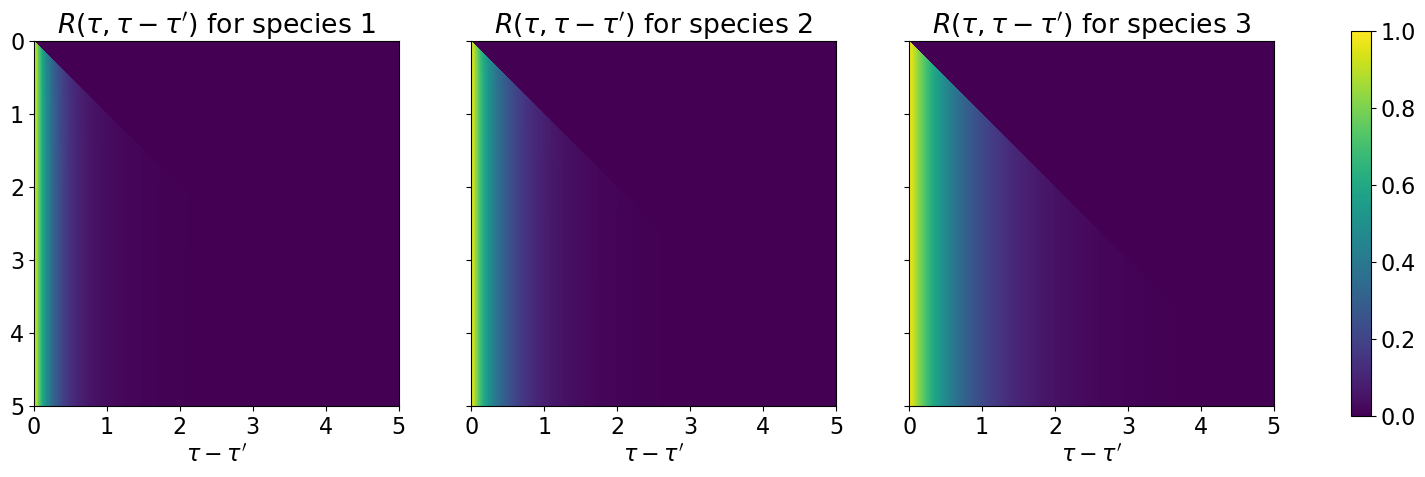

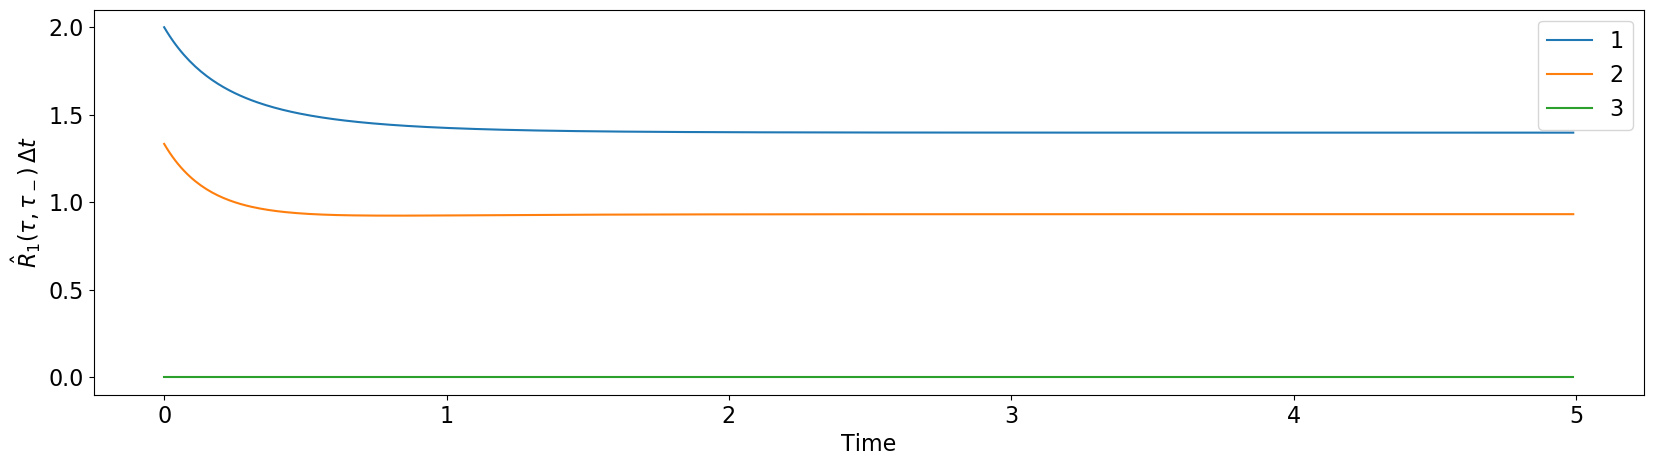

PyObject Text(43.17777777777776, 0.5, '$\\hat{R}_1(\\tau,\\tau_-)\\,\\Delta t$')

In [11]:
plf22 = Plefka(1.0, 2, "quad") # α, alphaOrder, orderParameter
res_plf_22 = euler_step(p, plf22)
plot_trajectories_and_deviation(res_plf_22[1], ref)
plot_hatTheta(ts, res_plf_22[3])
plot_responses(res_plf_22[2])
plot_hatR_diag(ts, res_plf_22[3])

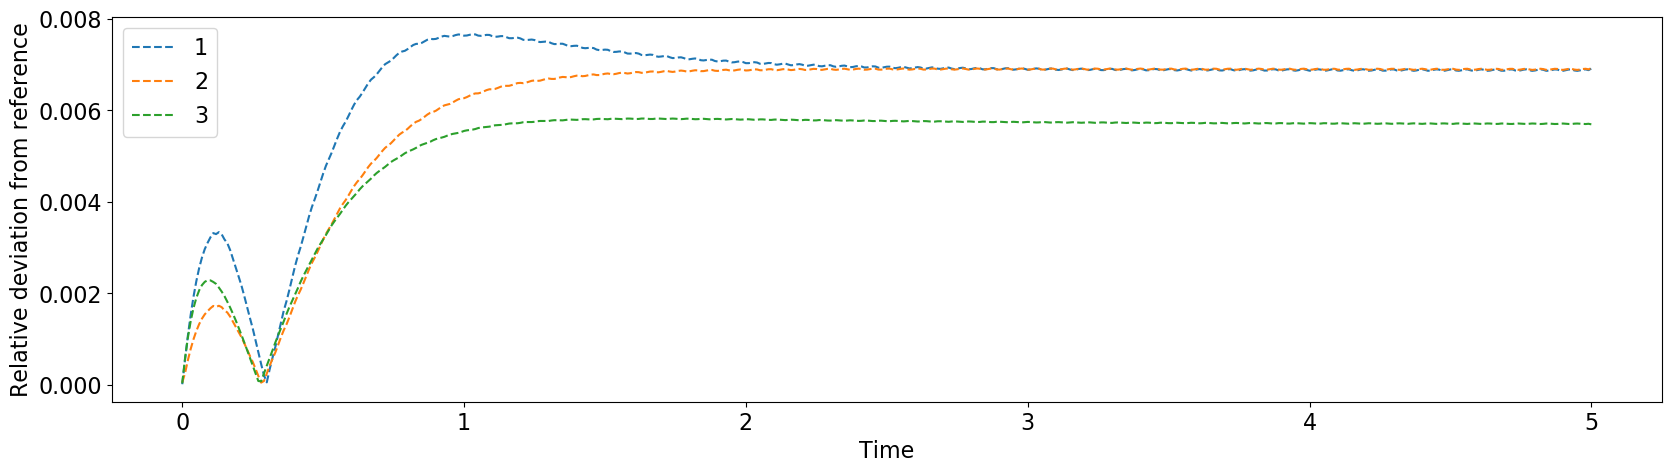

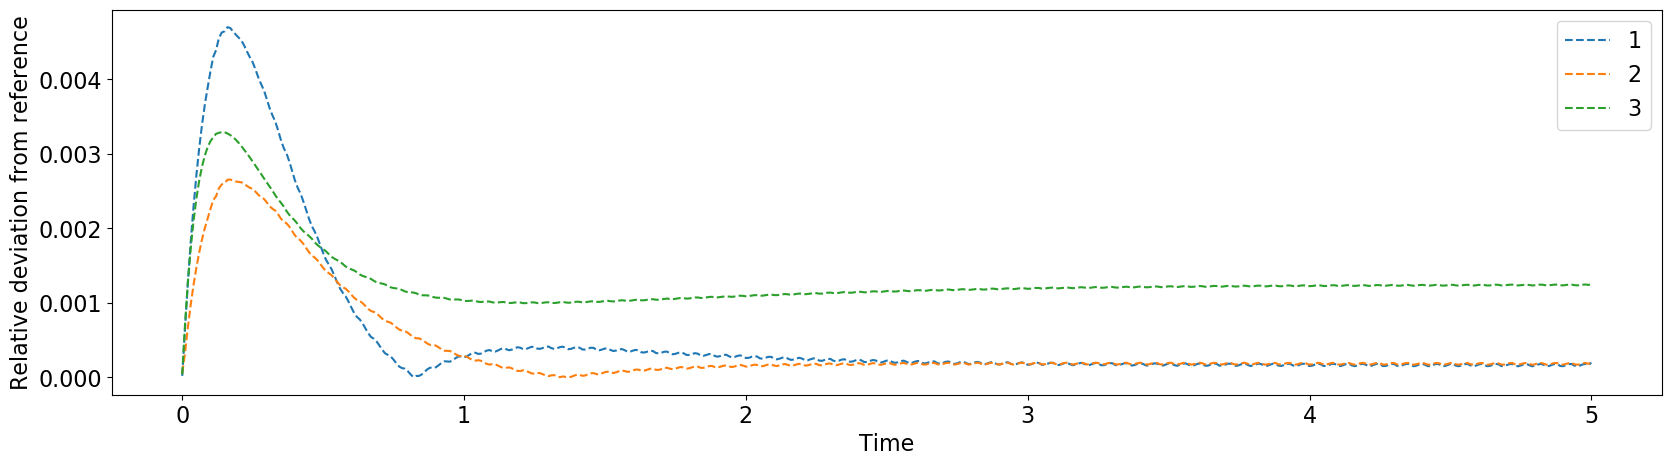

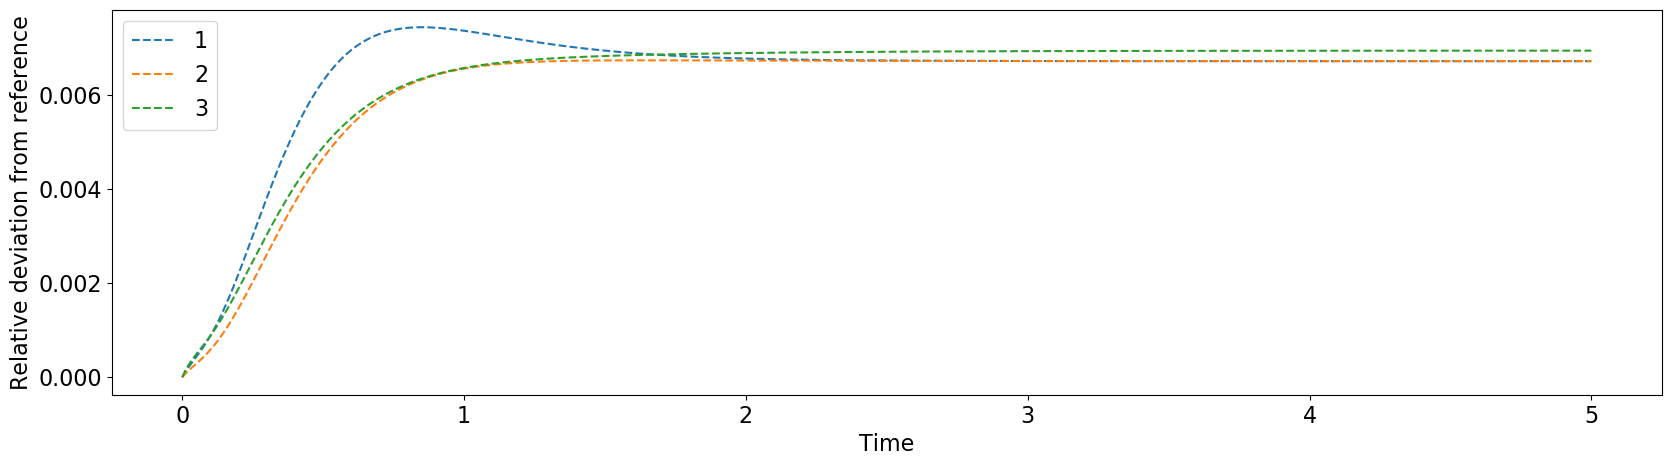

PyObject Text(32.999999999999986, 0.5, 'Relative deviation from reference')

In [12]:
plot_deviation(res_plf_21[1], ref)
plot_deviation(res_plf_22[1], ref)
plot_deviation(res_plf_21[1], res_plf_22[1])